In [1]:
import astropy.io.ascii as ascii
import numpy as np
import emcee
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import corner
%config InlineBackend.figure_format = 'retina'

# The Analysis of the HST Data

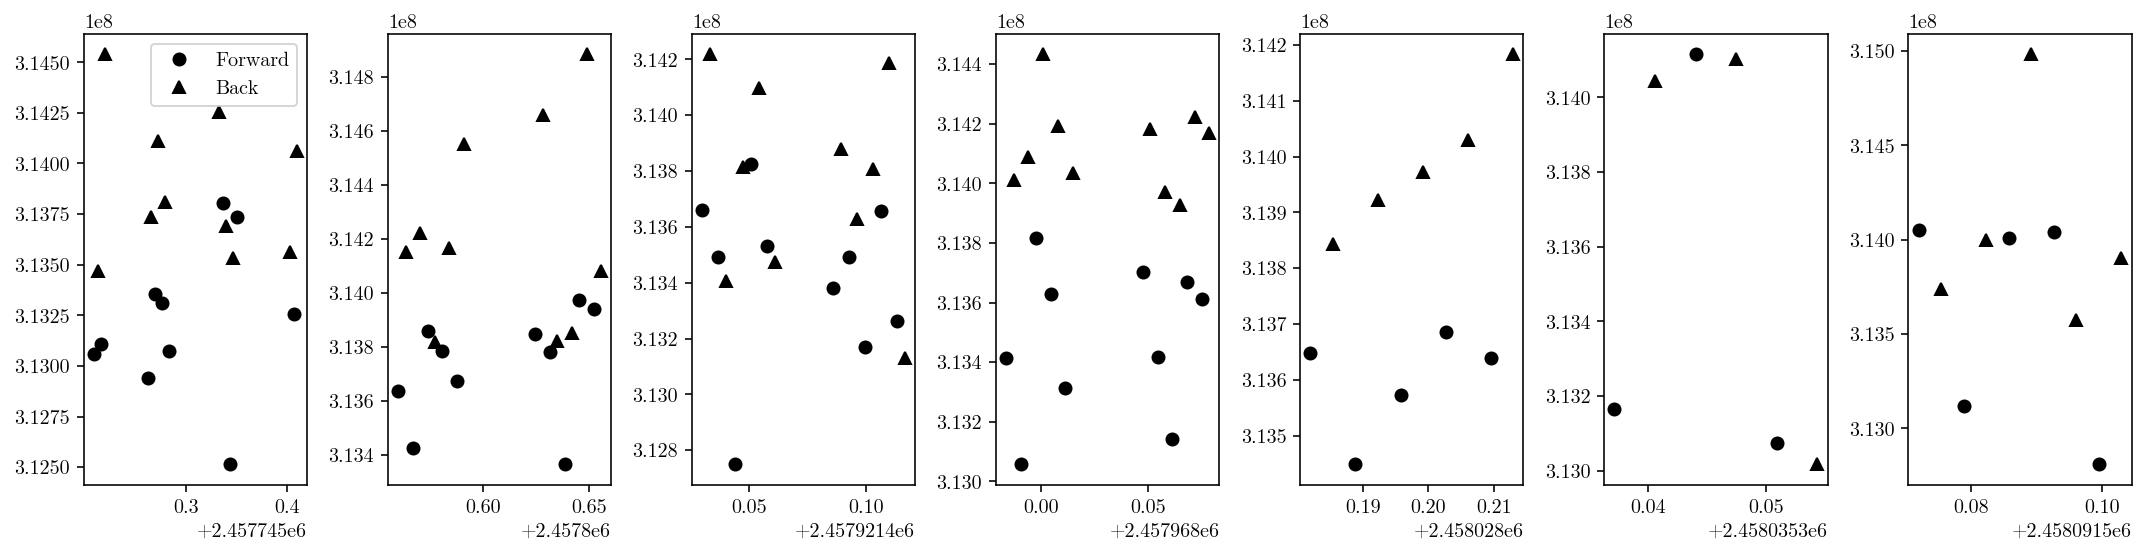

In [2]:
dats = []
for i in range(7):
    filename = "data/hst/BetaPic-RawFlux-v{0}.txt".format(i+1)
    dat = ascii.read(filename)

    times = dat['col1'].ravel()
    fluxes = dat['col2'].ravel()
    scan_dir = np.array([(-1)**i for i in range(times.shape[0])])
    
    # chop of last 4 pts of v6
    if i == 5:
        times = times[:-4]
        fluxes = fluxes[:-4]
        scan_dir = scan_dir[:-4]
    
    dats.append((times, fluxes, scan_dir))

    
fig = plt.figure(figsize=(15, 4))

for i in range(7):
    ax = fig.add_subplot(1, 7, i+1)
    
    times, fluxes, scan_dir = dats[i]
    forward = np.where(scan_dir > 0)
    back = np.where(scan_dir < 0)

    ax.plot(times[forward], fluxes[forward], 'ko', label="Forward")
    ax.plot(times[back], fluxes[back], 'k^', label="Back")

    if i == 0:
        plt.legend()


plt.tight_layout()

Define Quasi-Periodic Kernel

$ k_{ij} = A^2 \cos\left(2\pi t_{ij}/P_{osc}\right) (1 + \sqrt{3}t_{ij}/l) \exp\left(-\sqrt{3}t_{ij}/l\right) $

707000 0.03


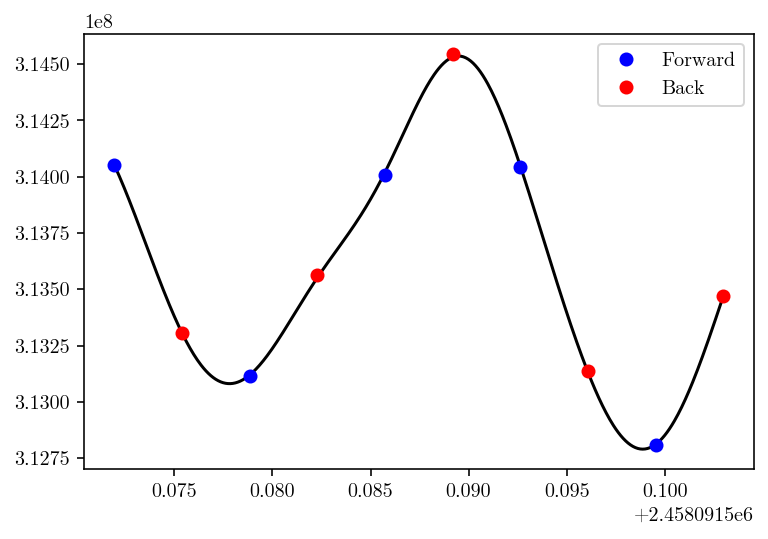

In [3]:
# guesses
guess_flux = np.mean(fluxes[forward])
guess_norm = np.mean(fluxes[forward])/np.mean(fluxes[back])

corr_len = 0.03
gp_amplitude = 707000
period_osc = 0.021
amplitude_osc = 0.5

def generate_kernel(t1, t2, corr_len, amplitude, p_osc, amp_osc=0):
    dt = np.abs(t1[:, None] - t2[None, :])

    arg1 = np.sqrt(3) * dt/corr_len
    arg2 = np.cos(2*np.pi*dt/p_osc)
    cov = amplitude**2 * arg2 * (1+arg1)*np.exp(-arg1)
  
    return cov


def gp_predict(times_wanted, t0, f0, scan_dir, guess_flux, guess_norm, corr_len, gp_amplitude, p_osc, amp_osc=0):
    """
    Predict fluxes between data points
    """
    forward = np.where(scan_dir > 0)
    back = np.where(scan_dir < 0)    
    
    corrected_fluxes = np.copy(f0)
    corrected_fluxes[back] *= guess_norm
    flux_res = corrected_fluxes - guess_flux
    
    # Compute the covariance matrices:
    K = generate_kernel(t0, t0, corr_len, gp_amplitude, p_osc, amp_osc)
    K[np.diag_indices_from(K)] += guess_flux  #adding photon noise
    Ks = generate_kernel(times_wanted, t0, corr_len, gp_amplitude, p_osc, amp_osc)
    Kss = generate_kernel(times_wanted, times_wanted, corr_len, gp_amplitude, p_osc, amp_osc)

    
    mu = np.dot(Ks, np.linalg.solve(K, flux_res))
    cov = Kss + np.dot(Ks, np.linalg.solve(K, Ks.T))
    
    mu += guess_flux
    return mu, cov
    
print(gp_amplitude, corr_len)

predicted_times = np.linspace(np.min(times), np.max(times), 500)
predicted_flux, _ = gp_predict(predicted_times, times, fluxes, scan_dir, guess_flux, guess_norm, corr_len, gp_amplitude, period_osc, amplitude_osc)


plt.plot()
plt.plot(predicted_times, predicted_flux, 'k-')
plt.plot(times[forward], fluxes[forward], 'bo', label="Forward")
plt.plot(times[back], fluxes[back]*guess_norm, 'ro', label="Back")

plt.legend()

plt.show()
        

In [20]:
# params
# 0-6: fluxes
# 7: back_scan_norm (log)
# 8: corr_length (log)
# 9: corr_amplitude (log)
# 10: peroid
# 11: noise amplification

def log_likelihood(thisparams, t0, f0, scan_dir):
    #print(thisparams)
    # Compute the covariance matrix:
    corr_len = np.exp(thisparams[2])
    amplitude = np.exp(thisparams[3])
    osc_period = np.exp(thisparams[4])
#     osc_amplitude = np.exp(params[5])
    back_scan_norm = np.exp(thisparams[1])
    noise_scale = np.exp(thisparams[-1])
    
    forward = np.where(scan_dir > 0)
    back = np.where(scan_dir < 0)
    
    residual_flux = np.copy(f0)
    residual_flux[back] *= back_scan_norm
    residual_flux -= thisparams[0]
    
    K = generate_kernel(t0, t0, corr_len, amplitude, osc_period)
    K[np.diag_indices_from(K)] += 1.575 * f0 * noise_scale**2 # adding noise (photon)
    
    # Compute the log likelihood:
    logl = -0.5 * np.dot(residual_flux, np.linalg.solve(K, residual_flux))
    logl -= 0.5 * np.linalg.slogdet(K)[1]
    return logl

def log_prior(params, dats):
    # Make sure that the parameters are all finite:
    if not np.all(np.isfinite(params)):
        return -np.inf
    
    # Bounds on the baseline flux in each epoch
    for i in range(7):
        if not np.min(dats[i][1])*0.9 <= params[i] < np.max(dats[i][1])*1.1:
            return -np.inf
        
    # Bounds on the back_scan_norm, 1 within a factor of 10
    if not np.log(0.1) <= params[7] < np.log(10):
        return -np.inf

    if not np.log(0.01) <= params[8] < np.log(0.5):
        return -np.inf

    if not np.log(5e4) <= params[9] < np.log(2e7):
        return -np.inf
    
    if not np.log(0.01) <= params[10] < np.log(0.04):
        return -np.inf
    
    if not np.log(1) <= params[11] < np.log(50):
        return -np.inf

    # flat prior
    return 0.0

def log_prob(params, dats):
    logp = log_prior(params, dats)
    if not np.isfinite(logp):
        return -np.inf
    
    logl = 0
    for i in range(7):
        t0, f0, scan_dir = dats[i]
        thisparams = [params[i], params[7], params[8], params[9], params[10], params[11]]
        logl += log_likelihood(thisparams, t0, f0, scan_dir)
        
    return logp + logl


guess_params = [np.mean(dats[i][1]) for i in range(7)]
guess_params += [ np.log(guess_norm), np.log(corr_len), np.log(gp_amplitude), np.log(period_osc), np.log(2)]

print(guess_params, len(guess_params))

# p0 = np.array(guess_params) + 1e-4 * np.array(guess_params) * np.random.randn(nwalkers, ndim)
# print(p0[0])

print(log_prob(guess_params, dats))
# print(log_prob(p0[0], dats))

[313546190.30278623, 313974129.3881222, 313592958.8225068, 313799957.8441504, 313794454.2528448, 313586771.9782979, 313822289.076807, -0.0013840312197990188, -3.506557897319982, 13.468785944878709, -3.863232841258714, 0.6931471805599453] 12
-1509.2783797847146


/home/jwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


313310560.90798056 [           inf            inf            inf            inf
            inf            inf 9.98463759e-01 1.00000151e-02
 3.31393088e+05 1.75546272e-02 1.62483731e+00]


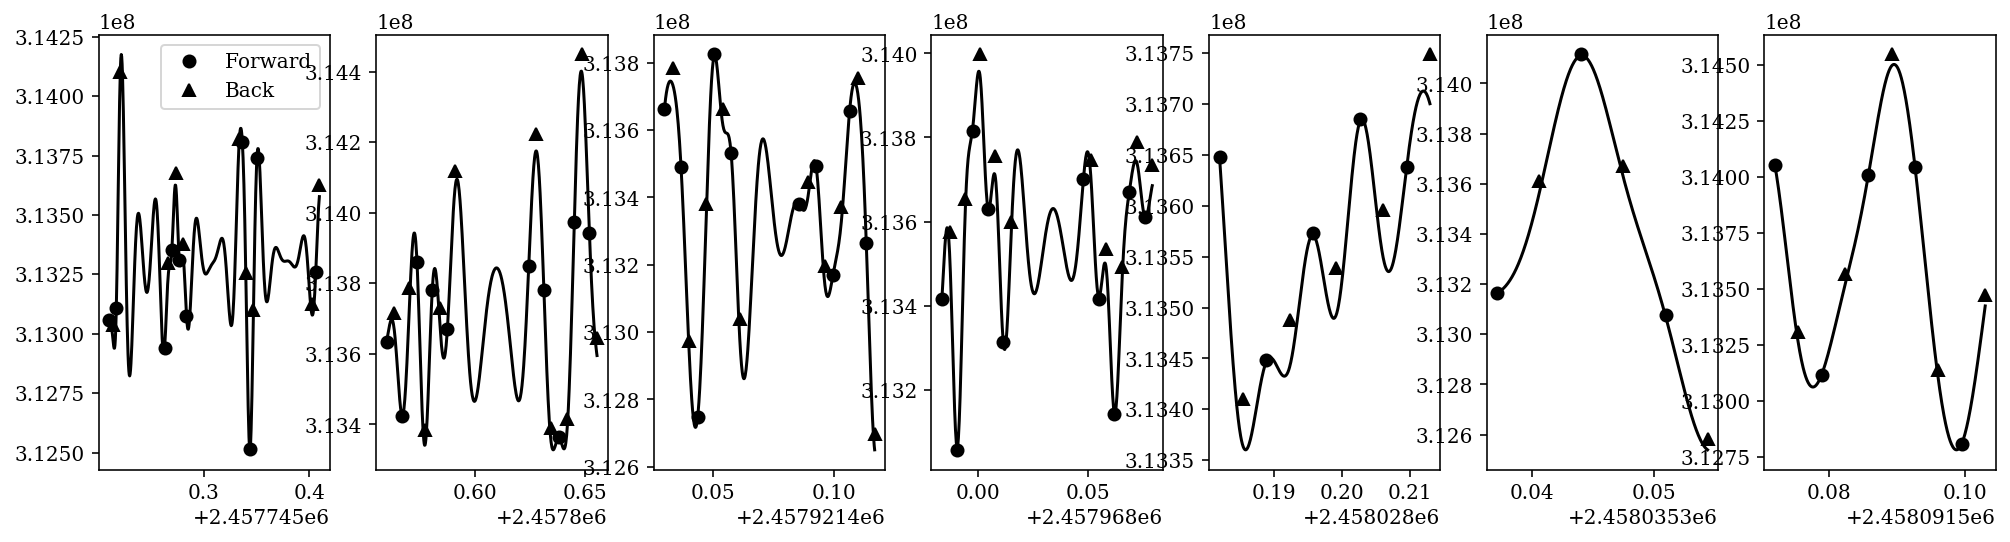

In [21]:
# inital lsqr fit
from scipy.optimize import minimize

bounds = [[np.min(dats[i][1]),  np.max(dats[i][1])] for i in range(7)]
bounds += [[ np.log(0.1), np.log(10)], [np.log(0.014), np.log(0.2)], [np.log(5e4), np.log(2e7)],[np.log(0.014), np.log(0.05)], [np.log(1), np.log(1.5)]]

def neg_logprob(params, dats):
    return -log_prob(params, dats)

result = minimize(neg_logprob, guess_params, args=(dats,), bounds=bounds, method='Nelder-Mead')
max_likeli_params = result.x #the solution array

print(max_likeli_params[0], np.exp(max_likeli_params[1:]))

mlike_fluxes = max_likeli_params[0:7]
mlike_norm = np.exp(max_likeli_params[7])
mlike_corrlength = np.exp(max_likeli_params[8])
mlike_gpamp = np.exp(max_likeli_params[9])
mlike_oscp = np.exp(max_likeli_params[10])
mlike_oscamp = np.exp(max_likeli_params[11])

    

fig = plt.figure(figsize=(17,4))

for i in range(7):

    times, fluxes, scan_dir = dats[i]
    

    forward = np.where(scan_dir > 0)
    back = np.where(scan_dir < 0)

    mlike_flux = mlike_fluxes[i]
    
    predicted_times = np.linspace(np.min(times), np.max(times), 500)
    predicted_flux, _ = gp_predict(predicted_times, times, fluxes, scan_dir, mlike_flux, mlike_norm, mlike_corrlength, mlike_gpamp, mlike_oscp, mlike_oscamp)


    ax = fig.add_subplot(1, 7, i+1)
    ax.plot(predicted_times, predicted_flux, 'k-')
    ax.plot(times[forward], fluxes[forward], 'ko', label="Forward")
    ax.plot(times[back], fluxes[back]*guess_norm, 'k^', label="Back")

    if i == 0:
        plt.legend()


In [22]:
# set up MCMC and run it
ndim, nwalkers = 12, 120

# Initialize the "walkers" in a ball around the best fit parameters from above:
p0 = np.array(guess_params) + 1e-4 * np.array(guess_params) * np.random.randn(nwalkers, ndim)

# Set up the sampler and run the first burn-in
gp_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(dats,))

print("Running burn-in #1...")
pos, lp, _ = gp_sampler.run_mcmc(p0, 1000)

# # Re-sample the walkers around the best sample after burn-in:
# pos = pos[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
gp_sampler.reset()

print("Running production chain...")
pos, _, _ = gp_sampler.run_mcmc(pos, 1500)

print("Finished")

Running burn-in #1...
Running production chain...
Finished


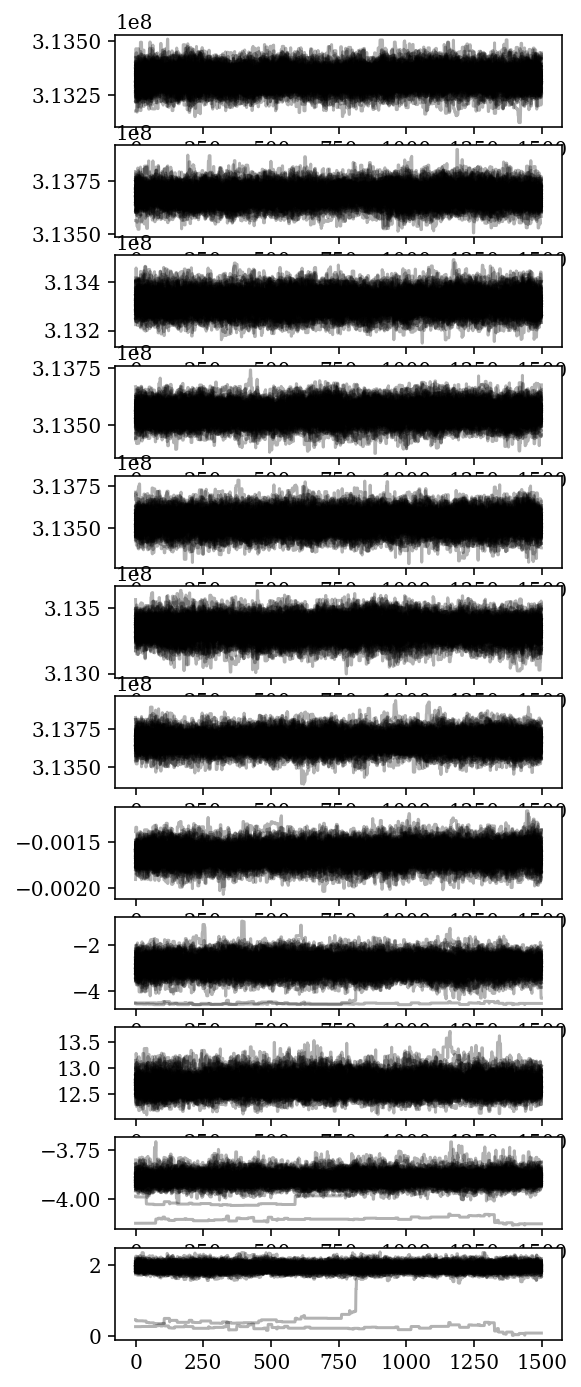

In [23]:
# inspect chains
fig = plt.figure(figsize=(4, 12))
for i in range(12):
    ax = fig.add_subplot(12,1,i+1)
    ax.plot(gp_sampler.chain[:,:,i].T, 'k-', alpha=0.3)
    

In [24]:
chain = gp_sampler.chain.reshape(nwalkers * 1500, ndim)
logchain = np.copy(chain)
lnlike = gp_sampler.lnprobability.reshape(nwalkers * 1500)
chain[:, 7:-1] = np.exp(chain[:, 7:-1])

print(lnlike)

[-1361.64850796 -1359.449352   -1361.68412265 ... -1361.32255909
 -1365.66638012 -1362.34036456]


In [25]:
# figure out how long each epoch is for plotting
dts = []

for i in range(7):
    times, fluxes, scan_dir = dats[i]
    dt = np.max(times) - np.min(times)
    dt *= 24
    dts.append(dt)
print(dts)
print(dts/(dts[-1] + 0.22))

[4.7838959991931915, 2.2941839955747128, 2.08389600366354, 2.277240000665188, 0.7450079955160618, 0.41387999430298805, 0.7450079955160618]
[4.95736411 2.37737304 2.15945983 2.35981465 0.77202261 0.42888763
 0.77202261]


# Make plot for the paper

0 5
0.0008571662163982715
5 8
0.01251749981194735
8 11
0.016898499643430116
11 14
0.012870499705895785
14 15
0.0045833333333333325
15 16
0.011481833358605703
16 17
0.0045833333333333325


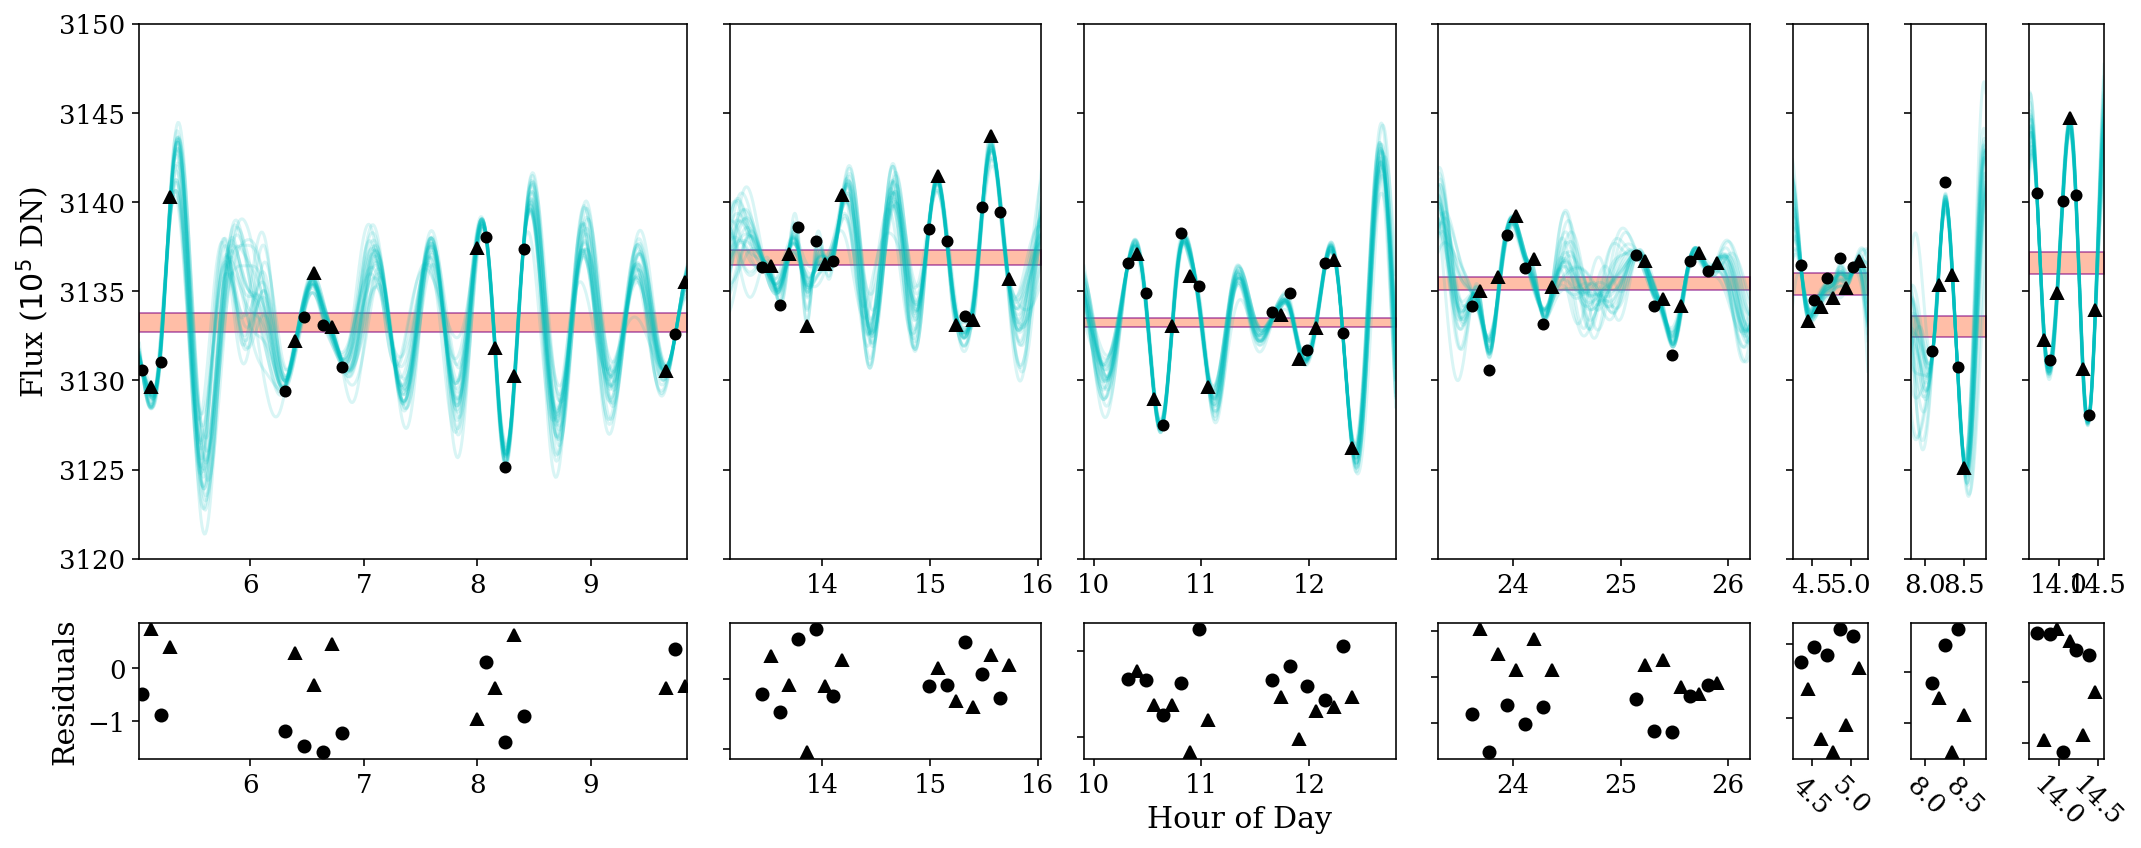

In [33]:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(4, 17)

figsizes = [5, 3, 3, 3, 1, 1, 1]
figloc = 0

# shortest time baseline to plto 
dt = dts[-1] + 0.22

share_y = None

norm = 1e5

for i in range(7):

    #ax = fig.add_subplot(1,7, i+1, sharey=None)
    print(figloc, figloc+figsizes[i])
    ax = plt.subplot(gs[0:3, figloc:figloc+figsizes[i]])
    ax_res = plt.subplot(gs[3, figloc:figloc+figsizes[i]])
    figloc += figsizes[i]
    if share_y is None:
        share_y = ax
    
    times, fluxes, scan_dir = dats[i]
    t2 = times - np.floor(times[0])
    t2_hours = t2 * 24

    forward = np.where(scan_dir > 0)
    back = np.where(scan_dir < 0)
    
    # figure out where the time limits should be for plotting. the x limit is controleld by predicted_times
    this_dt = 24 * (np.max(times) - np.min(times))
    time_padding = figsizes[i] * dt - this_dt
    time_padding /= 2*24
    print(time_padding)
    
    predicted_times = np.linspace(np.min(t2) - time_padding ,np.max(t2) + time_padding, 500)
    predicted_times_hours = predicted_times * 24

    res_arrays = []

    labelled = False

    gp_mean = []
    mcmc_mean = []
    
    for samp in np.random.randint((chain.shape[0]), size=25):
        rand_params = chain[samp]
        predicted_flux, _ = gp_predict(predicted_times, t2, fluxes, scan_dir, rand_params[i], rand_params[7], rand_params[8], rand_params[9], rand_params[10])
        gp_mean.append(np.mean(predicted_flux))
        mcmc_mean.append(rand_params[i])

        # save residuals
        prediction_against_data, _ = gp_predict(t2, t2, fluxes, scan_dir, rand_params[1], rand_params[7], rand_params[8], rand_params[9], rand_params[10])
        prediction_against_data[back] /= rand_params[7]
        res_arrays.append(fluxes - prediction_against_data)


        if not labelled:
            labelled = True
            ax.plot(predicted_times_hours, predicted_flux/norm, 'c-', alpha=0.15, label="Models")
        else:
            ax.plot(predicted_times_hours, predicted_flux/norm, 'c-', alpha=0.15)
            

    gpfluxrange = np.percentile(gp_mean, [16,50,84])
    mcmcfluxrange = np.percentile(mcmc_mean, [16,50,84])

    ax.fill_between(predicted_times_hours, mcmcfluxrange[0]/norm, mcmcfluxrange[2]/norm, facecolor='Coral', alpha=0.5, edgecolor='Purple',
                     label=r"Baseline Flux ($\pm 1\sigma$)")

    best_params = chain[np.argmax(lnlike)]


    back_norm_50 = np.percentile(chain[:,7], [16,50,84])[1]

    ax.plot(t2_hours[forward], fluxes[forward]/norm, 'ko', markersize=5, linestyle='none', label="Forward Scans")
    ax.plot(t2_hours[back], fluxes[back]*back_norm_50/norm, 'k^', label="Back Scans")

    ax_res.plot(t2_hours[forward], np.mean(res_arrays, axis=0)[forward]/norm, 'ko')
    ax_res.plot(t2_hours[back], np.mean(res_arrays, axis=0)[back]/norm, 'k^')
    
    ax.set_xlim([np.min(predicted_times_hours), np.max(predicted_times_hours)])
    ax_res.set_xlim([np.min(predicted_times_hours), np.max(predicted_times_hours)])
    #ax.legend(loc=1)
    if i == 2:
        ax_res.set_xlabel("Hour of Day", fontsize=15)
    
    ax.set_ylim([3.120e8/norm, 3.150e8/norm])
    
    if i == 0:
        ax.set_ylabel(r"Flux ($10^5$ DN)", fontsize=15)
        ax.yaxis.get_offset_text().set_fontsize(13)
        ax_res.set_ylabel("Residuals", fontsize=15)
    else:
        ax.axes.yaxis.set_ticklabels([])
        ax_res.axes.yaxis.set_ticklabels([])
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = 13)
    ax_res.tick_params(axis = 'both', which = 'major', labelsize = 13)
    if i > 3:
        plt.xticks(rotation=-45)


plt.tight_layout()
plt.savefig("visitall-gpfit-maternperiodic.pdf")
#plt.savefig("visitall-gpfit-maternperiodic.png", dpi=300)



313707588.7147557


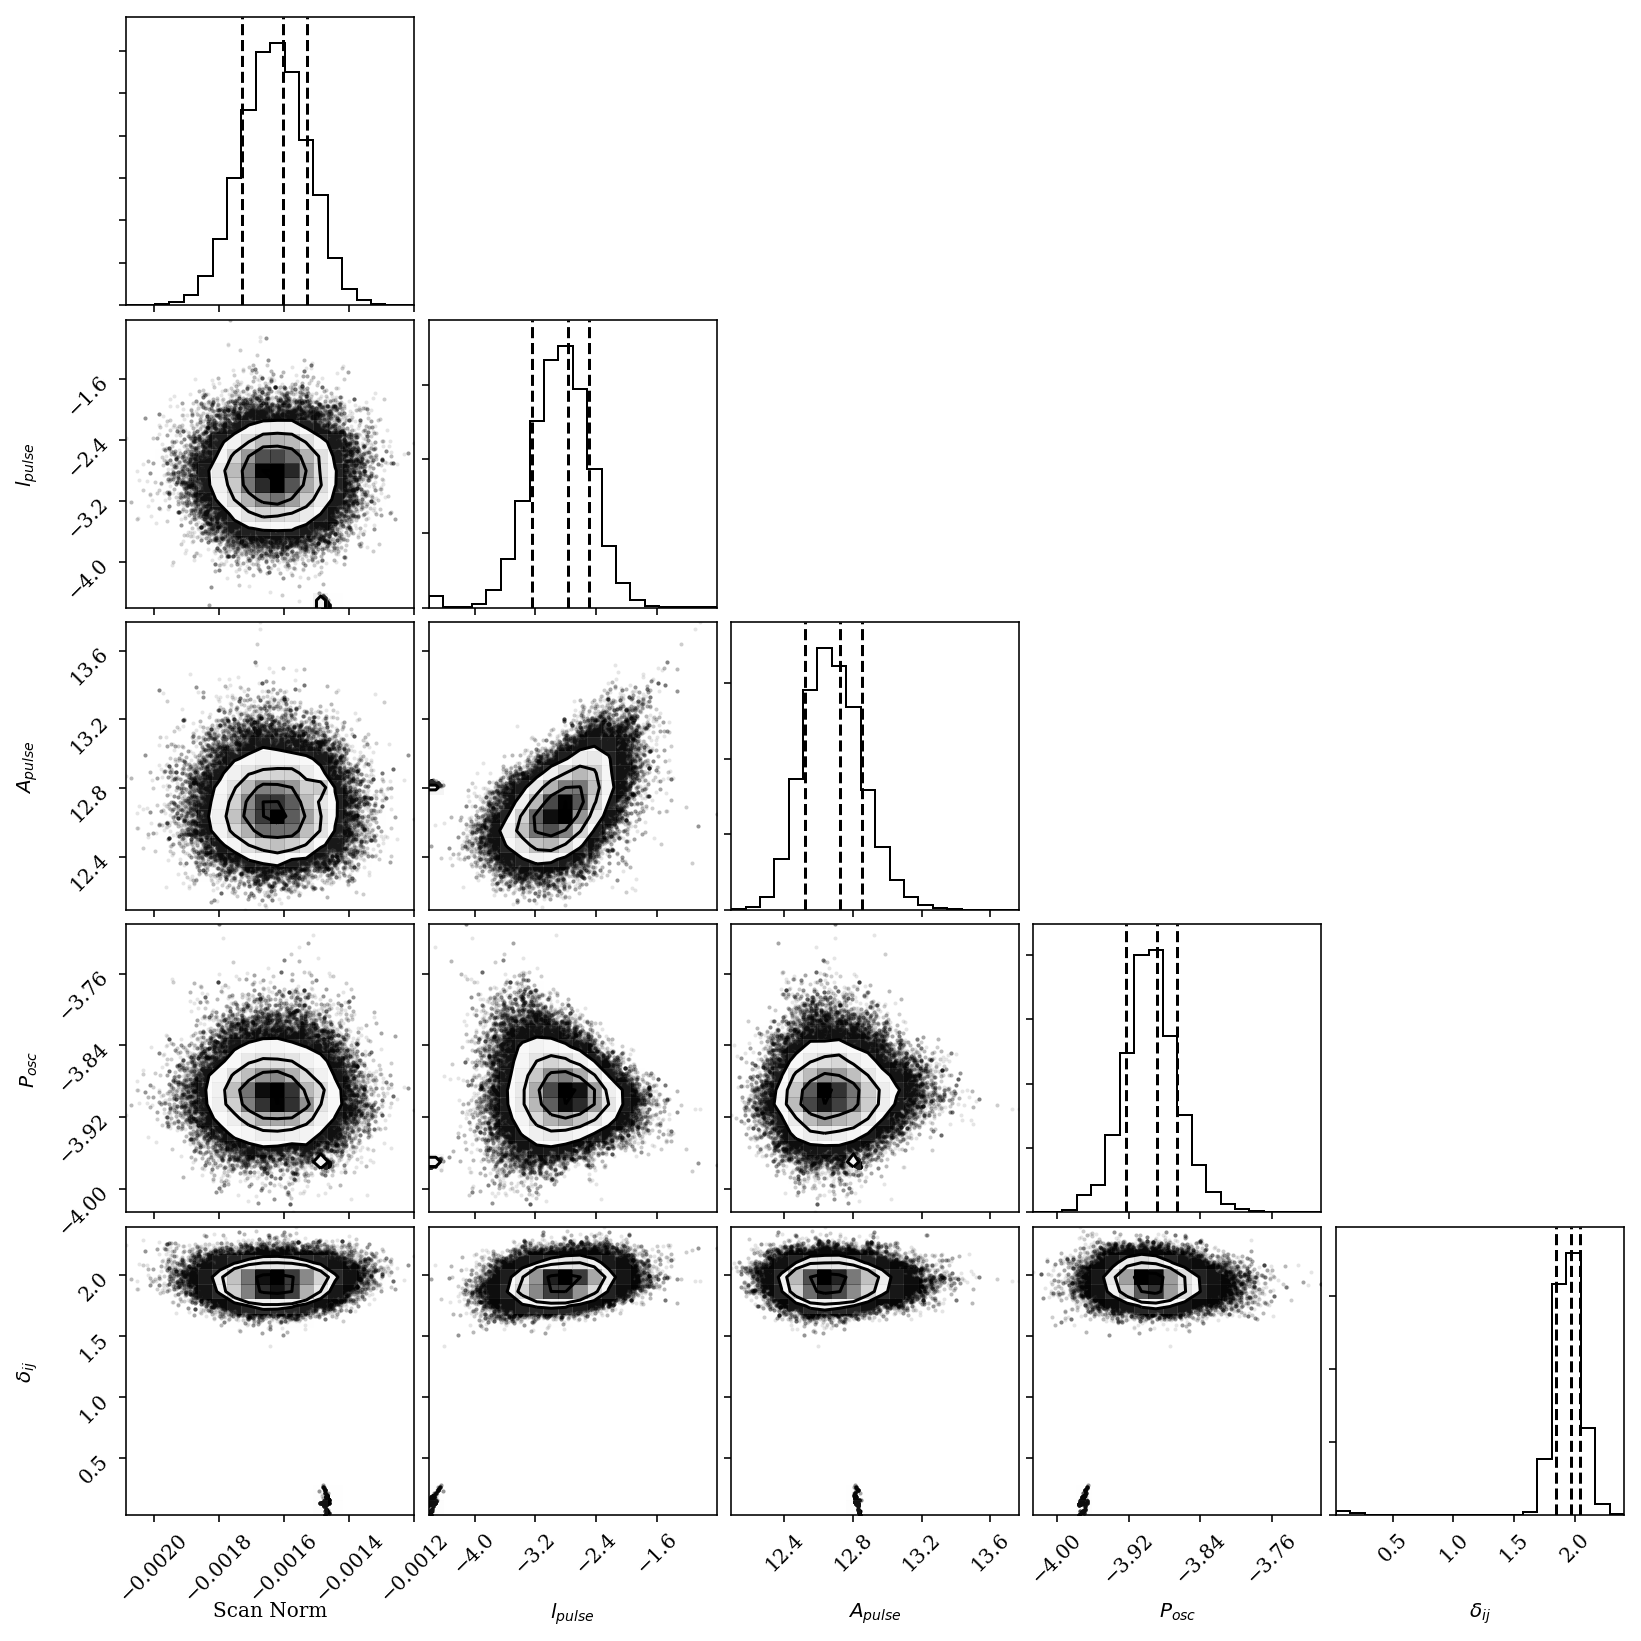

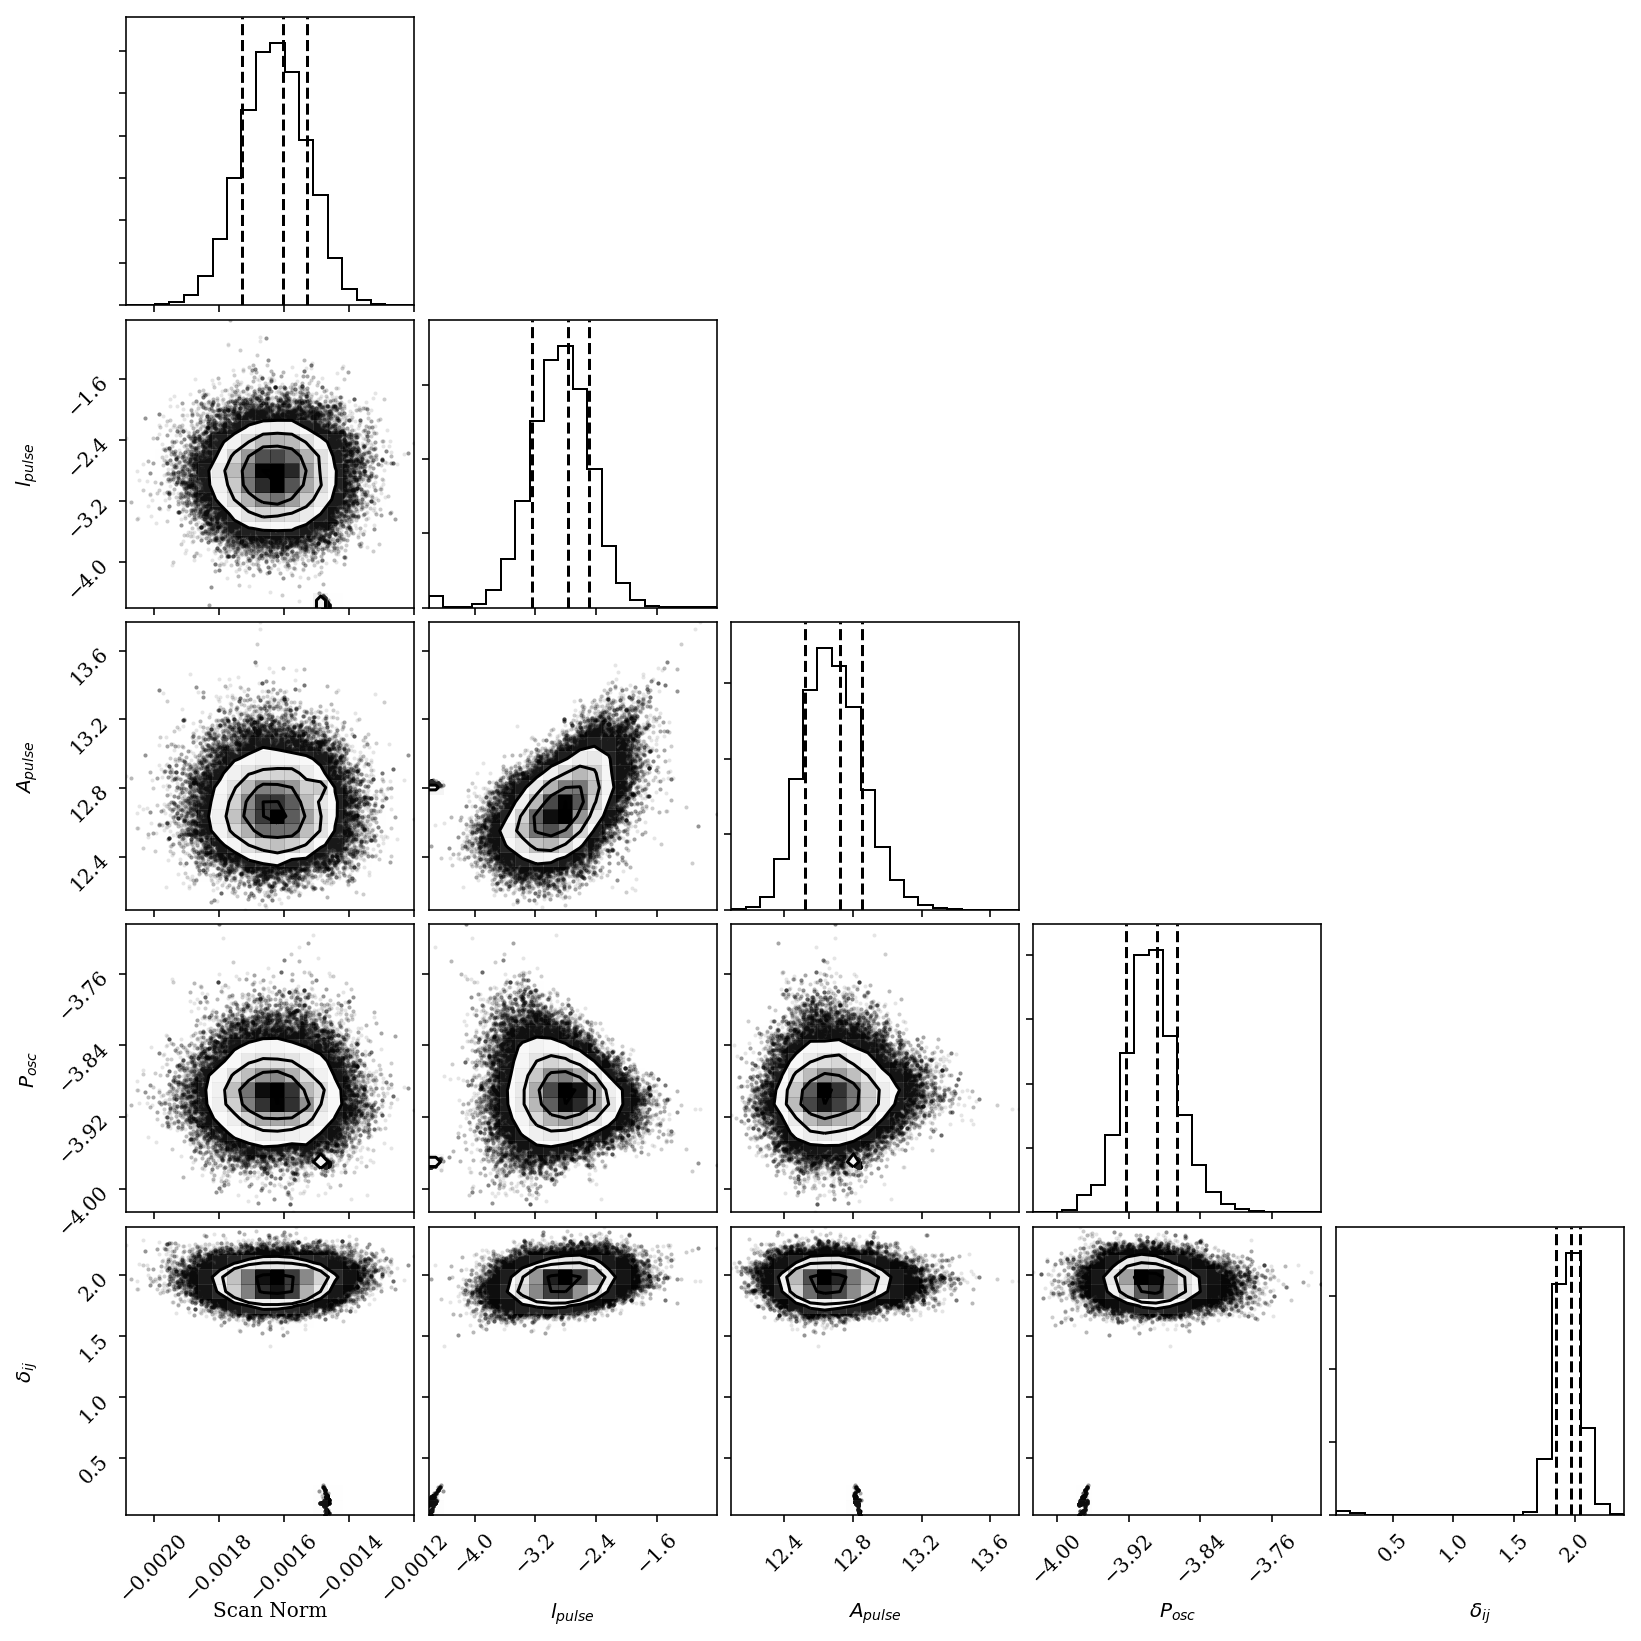

In [11]:
print(np.max(chain[:,3]))
gp_labels = [r"Flux", r"Scan Norm", r"$l_{pulse}$", r"$A_{pulse}$", r"$P_{osc}$", r"$B_{osc}$", r"$\delta_{ij}$" ]
gp_labels = [r"Scan Norm", r"$l_{pulse}$", r"$A_{pulse}$", r"$P_{osc}$", r"$\delta_{ij}$" ]
corner.corner(logchain[:, 7:], labels=gp_labels, quantiles=[0.16,0.6,0.84], plot_datapoints=True) #truths=chain[np.argmax(lnlike)],

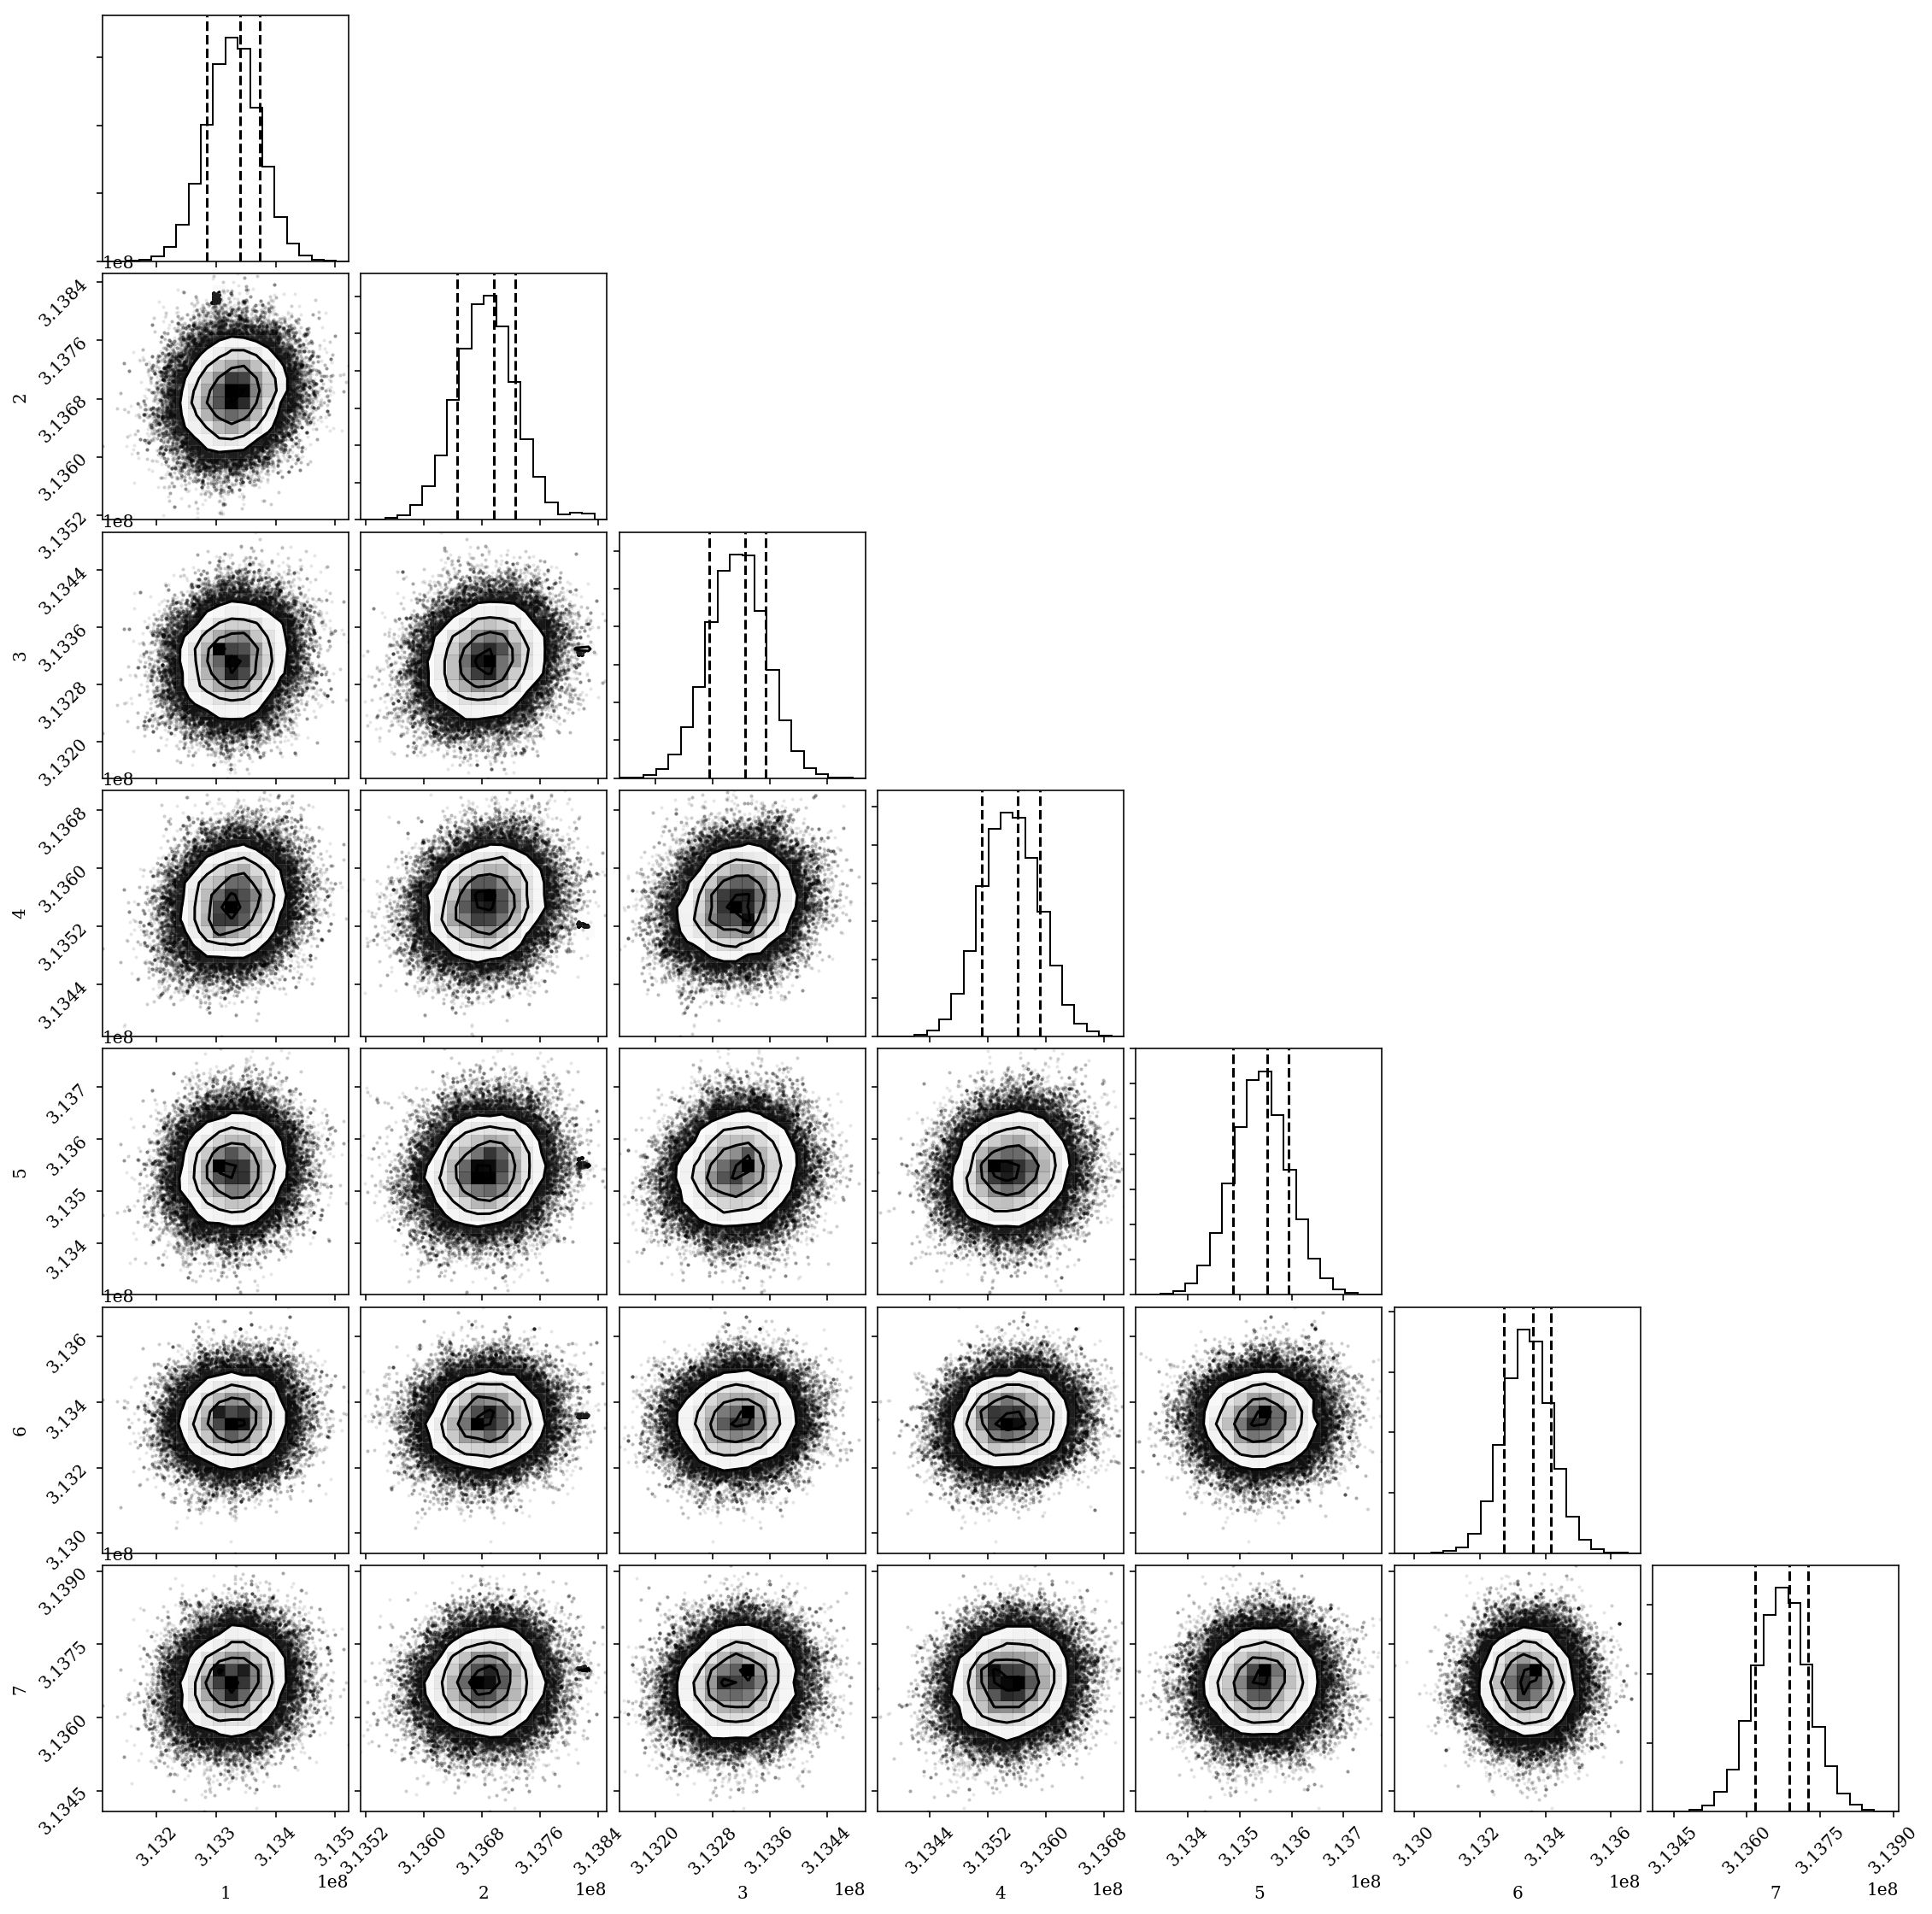

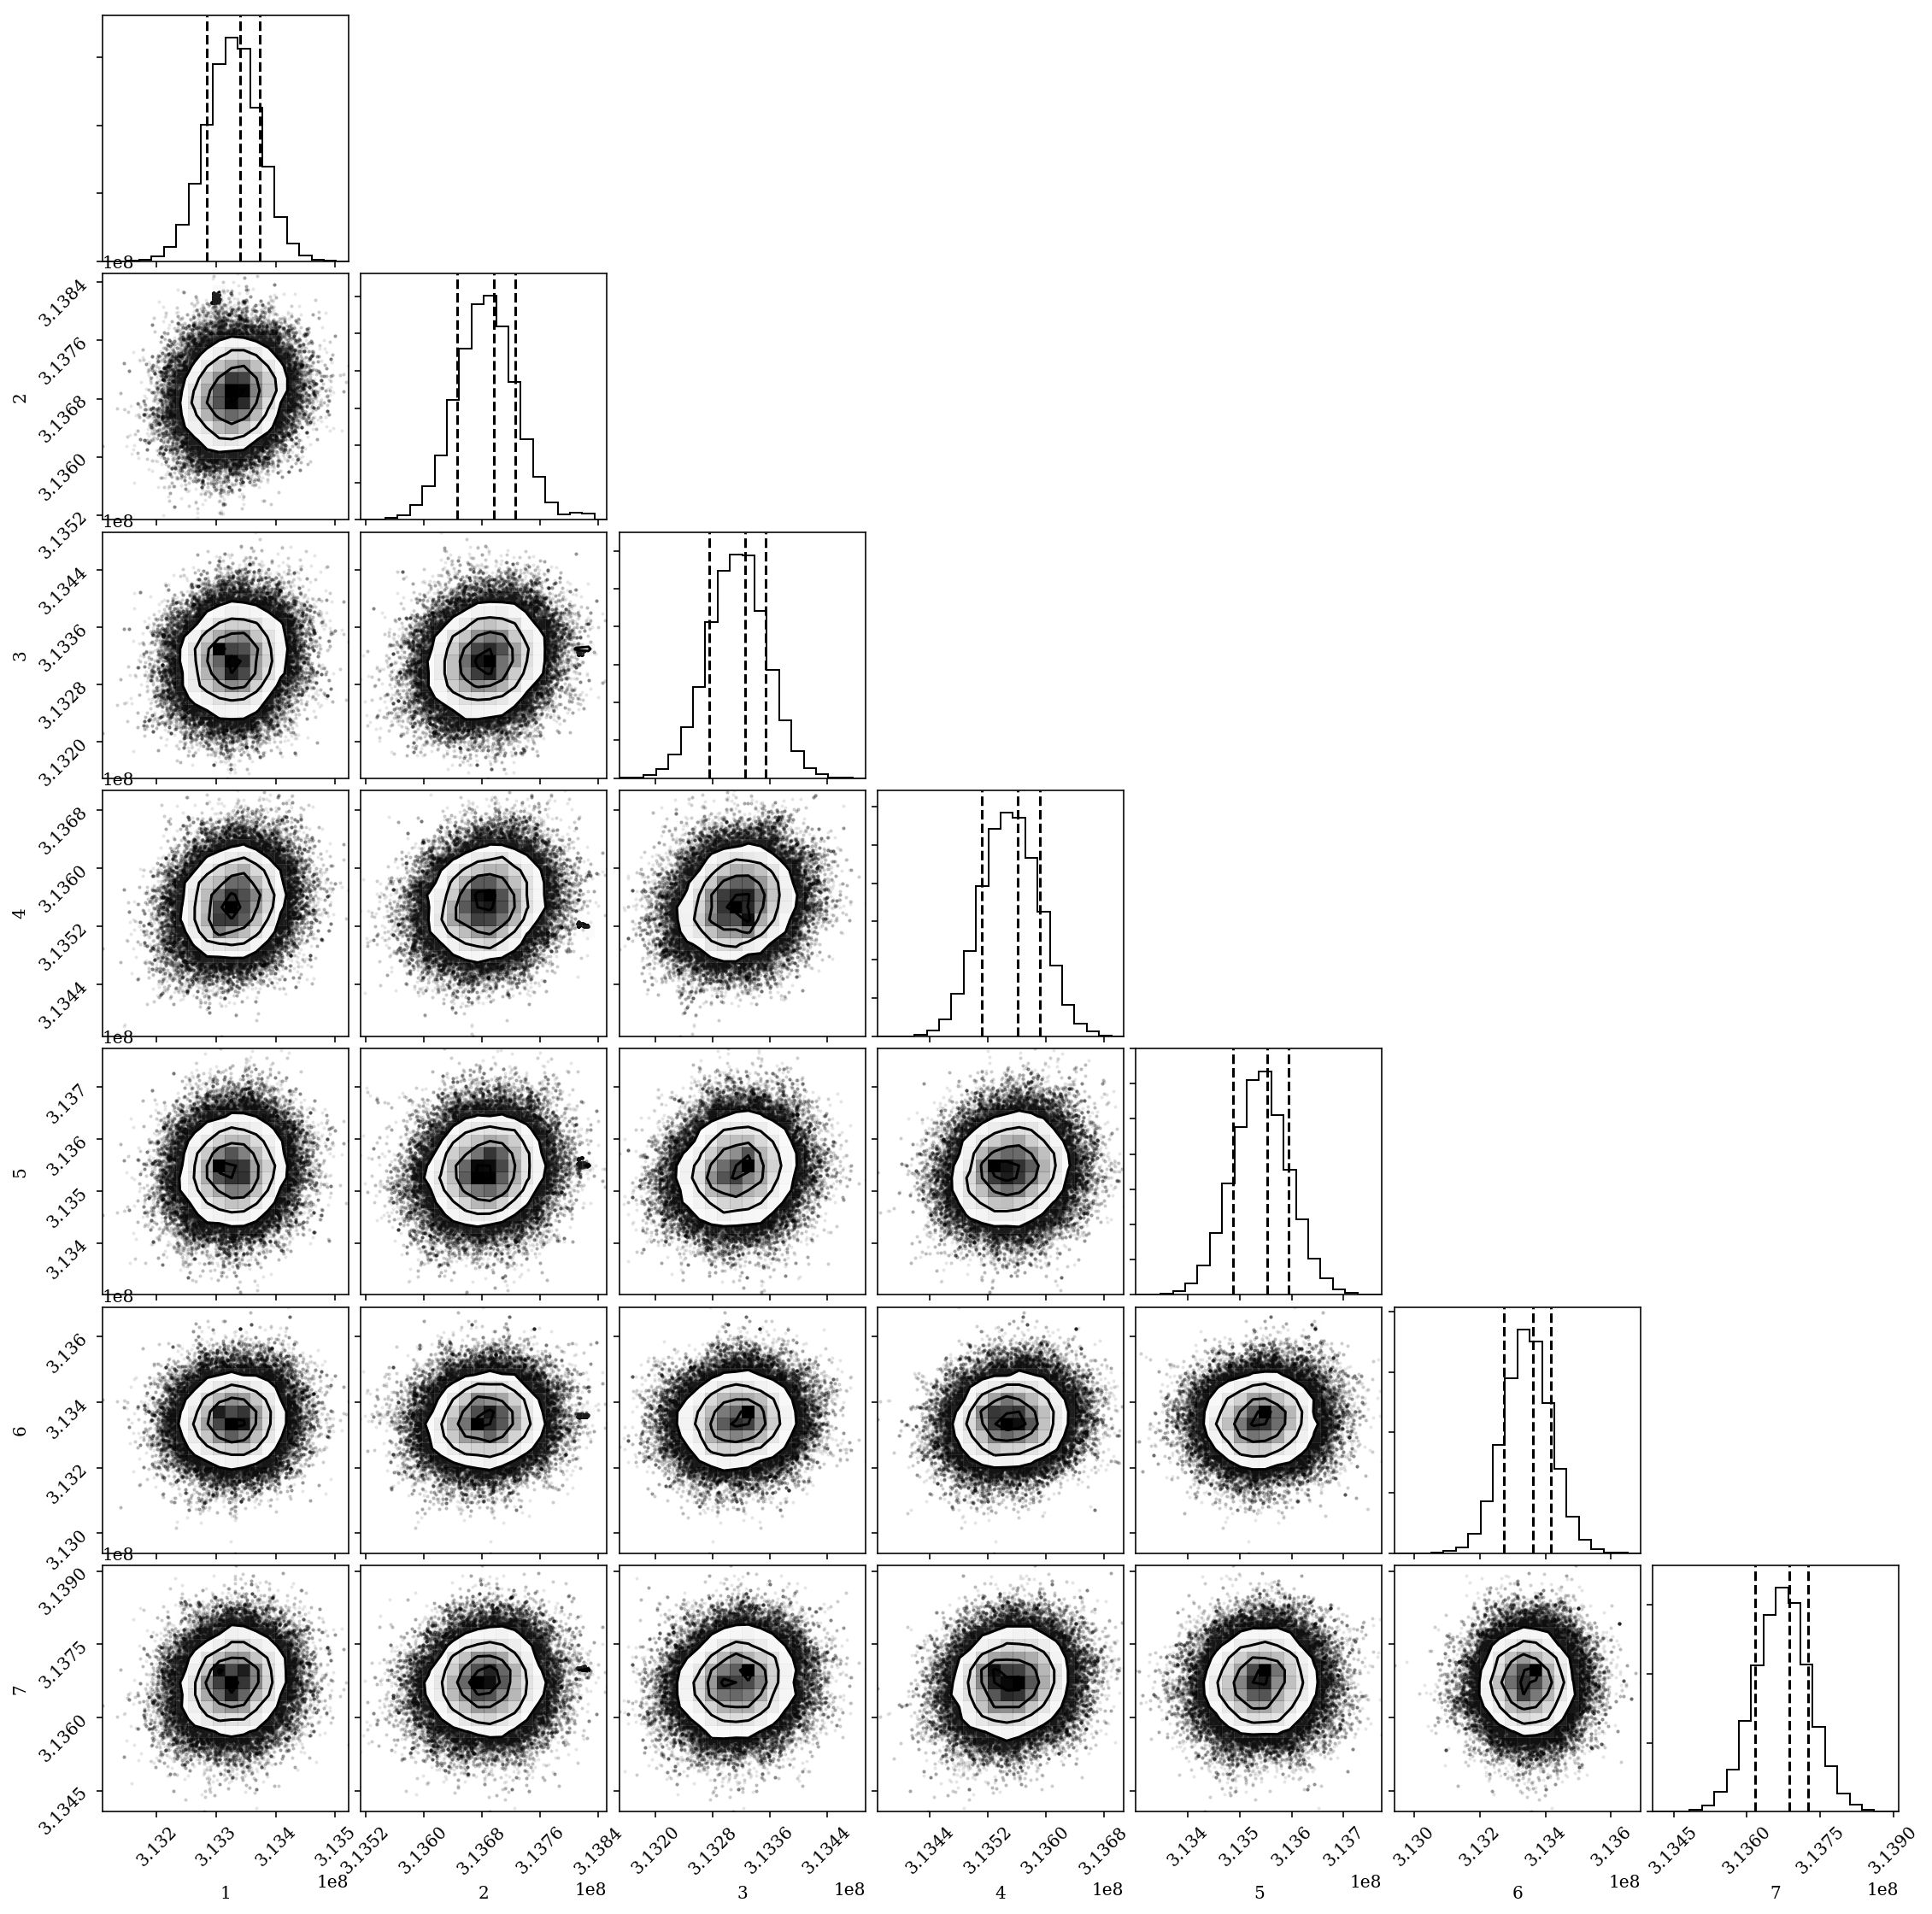

In [12]:

gp_labels = [r"1", r"2", r"3", r"4", r"5", "6", "7" ]
corner.corner(logchain[:, :7], labels=gp_labels, quantiles=[0.16,0.6,0.84], plot_datapoints=True) #truths=chain[np.argmax(lnlike)],

In [17]:
for i in range(7):
    tile = np.percentile(chain[:,i], [16,50,84])
    print("Flux in epoch {3}: {0} +{1}/-{2} ({4:.4f}%)".format(tile[1], tile[2]-tile[1], tile[1]-tile[0], i, np.mean([tile[1]-tile[0], tile[2]-tile[1]])/tile[1]*100 ))
    
for i in range(5):
    tile = np.percentile(chain[:,7+i], [16,50,84])
    print("Hyperparam {3}: {0} +{1}/-{2} ({4:.4f}%)".format(tile[1], tile[2]-tile[1], tile[1]-tile[0], i, np.mean([tile[1]-tile[0], tile[2]-tile[1]])/tile[1]*100))
    
tile = np.percentile(1./chain[:,-2], [16,50,84])
print("Cycles/day: {0} +{1}/-{2}".format(tile[1], tile[2]-tile[1], tile[1]-tile[0]))
tile = np.percentile(24*60*chain[:,-2], [16,50,84])
print("Period (min): {0} +{1}/-{2}".format(tile[1], tile[2]-tile[1], tile[1]-tile[0]))

tile = np.percentile(1./chain[:,-5], [16,50,84])
print("Backwards scan direction normaliation: {0} +{1}/-{2}".format(tile[1], tile[2]-tile[1], tile[1]-tile[0]))
                                      

Flux in epoch 0: 313328521.37213194 +43982.60249942541/-44323.36387127638 (0.0141%)
Flux in epoch 1: 313686165.74579734 +39609.197555720806/-40214.149179279804 (0.0127%)
Flux in epoch 2: 313314934.1512852 +39657.1620002985/-40138.85615491867 (0.0127%)
Flux in epoch 3: 313551343.58347803 +40108.77173727751/-39122.13501757383 (0.0126%)
Flux in epoch 4: 313540404.9137595 +53782.12862998247/-53543.96672642231 (0.0171%)
Flux in epoch 5: 313344701.8943847 +71845.74656480551/-72217.46099191904 (0.0230%)
Flux in epoch 6: 313672329.67417544 +53779.95435720682/-56262.174128592014 (0.0175%)
Hyperparam 0: 0.998371889655756 +9.954508905340997e-05/-9.914639093566713e-05 (0.0100%)
Hyperparam 1: 0.05682005360687364 +0.025246542207217705/-0.01787005700583181 (37.9414%)
Hyperparam 2: 320069.77773510566 +61779.94583009271/-46983.93030810665 (16.9907%)
Hyperparam 3: 0.02033210412288283 +0.0006022875505495087/-0.0005413600984577431 (2.8124%)
Hyperparam 4: 1.9393322207121235 +0.10107672197126627/-0.09950782

In [14]:
np.median(chain[:,:7], axis=1)

array([3.13557847e+08, 3.13557710e+08, 3.13551738e+08, ...,
       3.13558671e+08, 3.13560037e+08, 3.13562523e+08])